# Content
Time series clustering using K means with Euclidean and DTW distance

How to decide the number of clusters ?

How can we calculate performance of clustering ?

In [132]:
%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd
import matplotlib


tslearn is a Python package that provides machine learning tools for the analysis of time series.

In [133]:
data = pd.read_csv('./data/data_long.csv')

def listify(row):
    row = str(row).replace('[', '').replace(']', '').split(',')
    row = [float(y) for y in row]

    return np.asarray(row)

data.loc[:, 'points'] = data.loc[:, 'points'].apply(listify)

In [134]:
points = data['points']

In [135]:
points = np.array(points.values.tolist())
points.resize(1864, 900, 1)
print(points.shape)

(1864, 900, 1)


## Note on pre-processing
**In this example, time series are preprocessed using TimeSeriesScalerMeanVariance.** 
This scaler is such that each output time series has zero mean and unit variance. 
The assumption here is that the range of a given time series is uninformative and one only wants to compare shapes.

In [136]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(points)
sz = X_train.shape[1]

## plot
Let's plot data, as groups based on provided labels

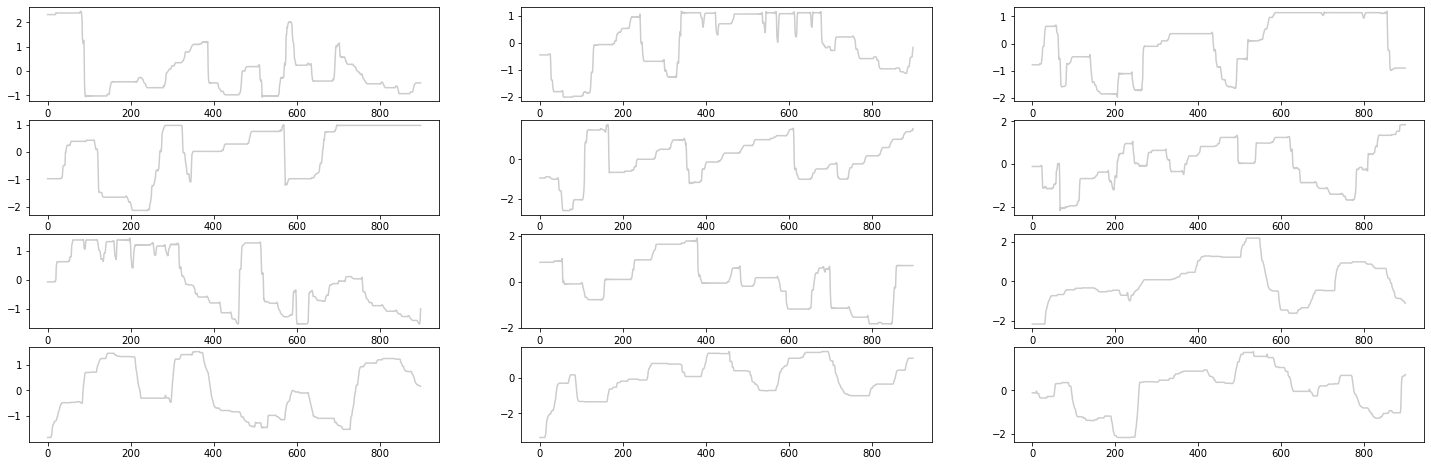

In [137]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

## No. of clusters decision

### Using inertia (sum of squared distances)

In [141]:
####################################### Getting number of optimal clusters #######################################

Sum_of_squared_distances = []
K = [10, 20, 27, 30]
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=0,
                          n_jobs=-1)
    
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

Init 1
579.822 --> 400.560 --> 390.786 --> 387.422 --> 385.688 --> 384.758 --> 384.140 --> 383.737 --> 383.266 --> 382.859 --> 382.520 --> 382.245 --> 381.943 --> 381.618 --> 381.520 --> 381.464 --> 381.412 --> 381.382 --> 381.333 --> 381.277 --> 381.254 --> 381.250 --> 381.245 --> 381.241 --> 381.237 --> 381.237 --> 
Init 2
558.226 --> 400.015 --> 388.810 --> 385.367 --> 384.104 --> 383.510 --> 383.111 --> 382.841 --> 382.725 --> 382.622 --> 382.576 --> 382.555 --> 382.543 --> 382.508 --> 382.502 --> 382.488 --> 382.472 --> 382.447 --> 382.439 --> 382.436 --> 382.432 --> 382.431 --> 382.431 --> 
Init 1
474.643 --> 351.485 --> 341.838 --> 337.558 --> 335.149 --> 333.489 --> 332.572 --> 331.997 --> 331.504 --> 331.124 --> 330.754 --> 330.523 --> 330.417 --> 330.366 --> 330.262 --> 330.225 --> 330.212 --> 330.212 --> 
Init 2
453.493 --> 348.622 --> 341.337 --> 337.751 --> 335.698 --> 334.424 --> 333.572 --> 332.759 --> 332.145 --> 331.710 --> 331.440 --> 331.201 --> 331.071 --> 331.008 -

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot, we can see that after cluster = N, plot flattens, so optimum number of clusters = N

### Using Silhoutte score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

X = train_pca

range_n_clusters = [27]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


## Training the model
  - using Euclidean distance

In [139]:
# Euclidean k-means
n_clusters = 27

print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
cluster_labels = km.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, cluster_labels, metric="euclidean")))

# Plot each average curve independently:
for yi in range(n_clusters):
    plt.plot(km.cluster_centers_[yi].ravel(), "r-", linewidth=40)
    plt.tight_layout()

    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.axis('off')

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 18.5)

    plt.savefig("./plots/cluster/cluster_{}.png".format(yi))
    plt.close()


plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, 9, yi + 1)
    for xx in X_train[cluster_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")

    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

    print("Cluster {} done!".format(yi))

data['cluster_labels'] = cluster_labels
data.to_csv("./data/data_long_cluster.csv")
plt.tight_layout()
plt.savefig("./plots/cluster/k_means.png", dpi=1000)
plt.close()

Euclidean k-means
Euclidean silhoutte: 0.08
Cluster 0 done!
Cluster 1 done!
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!
Cluster 9 done!
Cluster 10 done!
Cluster 11 done!
Cluster 12 done!
Cluster 13 done!
Cluster 14 done!
Cluster 15 done!
Cluster 16 done!
Cluster 17 done!
Cluster 18 done!
Cluster 19 done!
Cluster 20 done!
Cluster 21 done!
Cluster 22 done!
Cluster 23 done!
Cluster 24 done!
Cluster 25 done!
Cluster 26 done!


 # Training the model
  - Using DTW (Dynamic Time Warping) Distance

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed,
                          n_jobs=-1)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, 9, yi+1)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

    print("Cluster {} done!".format(yi))

plt.tight_layout()
plt.savefig("./plots/dba_k_means.png", dpi=1000)
plt.close()


# All plots together

In [ ]:
## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_train == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")
        
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 4)
    for xx in X_train[cluster_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 7)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

## with PCA : improvement ?

In [ ]:
from sklearn.cluster import KMeans
import math

train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=4, verbose=False, random_state=seed)
cluster_labels = km.fit_predict(train_pca)


print("silhoutte after PCA transformation: {:.2f}".format(silhouette_score(X_train, cluster_labels, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[cluster_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.tight_layout()
plt.show()

## Performance on test data

In [ ]:
n_clusters = 3

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_test[y_test == yi+1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")


# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
cluster_labels = km.fit_predict(X_test)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test, cluster_labels, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 4)
    for xx in X_test[cluster_labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_test)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 7)
    for xx in X_test[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()